In [1]:
import boto3
import os
from botocore import UNSIGNED
from botocore.config import Config
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.merge import merge
import rasterio.mask
from PIL import Image
from pyproj import Transformer
from shapely.geometry import box
from shapely.geometry import box, GeometryCollection, MultiPolygon, polygon, shape
import json

In [2]:
# a few raster functions

def merge_rasters(files, outfile: str = "test.tif") -> None:
    """
    Merge a list of geotiffs into one file
    """
    src_files_to_mosaic = []
    for fp in files:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    crs = src.crs
    out_meta = src.meta.copy()
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Update the metadata
    out_meta.update(
        {
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans,
            "crs": crs,
        }
    )

    with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE", BIGTIFF='YES') as dest:
        dest.write(mosaic)

def crop_raster(rasterfile: str, aoifile:str, outfile: str = "test.tif", nodata=255):
    gdf_aoi=gp.read_file(aoifile)
    with rasterio.open(rasterfile) as src:
            out_meta = src.meta.copy()
            if not src.crs == gdf_aoi.crs:
                gdf_aoi=gdf_aoi.to_crs(src.crs)
            aoi=gdf_aoi.iloc[0].geometry
            im, trans = rasterio.mask.mask(
                src, [aoi], crop=True, nodata=nodata, all_touched=True
            )
            # Update the metadata
            out_meta.update(
            {
                "driver": "GTiff",
                "height": im.shape[1],
                "width": im.shape[2],
                "transform": trans,
                "crs": src.crs,
                "nodata": nodata,
            }
            )
    with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE", BIGTIFF='YES') as dest:
        dest.write(im)

def enforce_mask(file, outfile=None, nodata=255):
    if not outfile:
        outfile=file.replace('.tif', 'masked.tif')
    with rasterio.open(file) as src:
        mask=src.read_masks()
        data=src.read()
        #nodata has been assigned as 255 in the S3 .msk files
        data[mask==255]=nodata
        out_meta=src.meta
        out_meta.update(
            {"nodata":nodata}
        )
        with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE") as dest:
            dest.write(data)

In [3]:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [4]:
bucket='dataforgood-fb-data'
localdir='/Users/jetolan/Desktop/ICMBIO/data'

In [5]:
#chm geotiffs are tiled in web mercator tiles globally
#download poygons for global tiles
s3file='forests/v1/alsgedi_global_v6_float/tiles.geojson'
localfile=f"{localdir}/{os.path.basename(s3file)}"
if not os.path.exists(localfile):
    s3_client.download_file(bucket, s3file, localfile)

In [6]:
tiles=gp.read_file(localfile)

<Axes: >

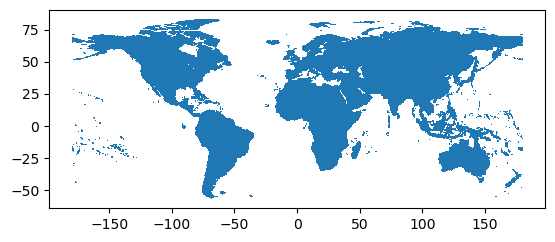

In [7]:
tiles.plot()

<Axes: >

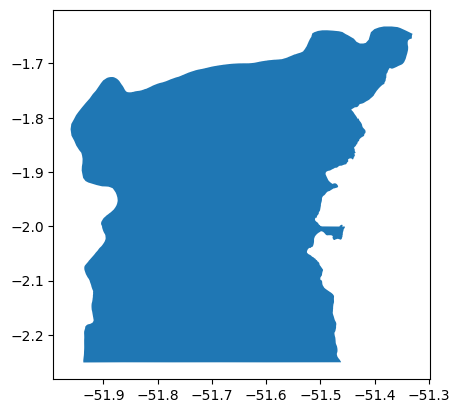

In [8]:
#here is the polygon we are interested in
target_polyfile='/Users/jetolan/Desktop/ICMBIO/caxiuana.geojson'
target=gp.read_file(target_polyfile)
target.plot()

In [10]:
#find tiles that contain the target polygon
target_tiles=gp.sjoin(tiles, target)

In [11]:
#download data from AWS S3
s3chmpath='forests/v1/alsgedi_global_v6_float/chm'
s3mskpath='forests/v1/alsgedi_global_v6_float/msk'
s3metapath='forests/v1/alsgedi_global_v6_float/metadata'
tifs=[]
metas=[]
for ii, row in target_tiles.iterrows():
    print(row.tile)

    #download chm
    s3file=f"{s3chmpath}/{row.tile}.tif"
    localfile=f"{localdir}/{os.path.basename(s3file)}"
    if not os.path.exists(localfile):
        s3_client.download_file(bucket, s3file, localfile)

    #also download cload masks
    mskfile=f"{s3mskpath}/{row.tile}.tif.msk"
    localmskfile=f"{localdir}/{os.path.basename(mskfile)}"
    if not os.path.exists(localmskfile):
        s3_client.download_file(bucket, mskfile, localmskfile)

    #download metadata
    jsonfile=f"{s3metapath}/{row.tile}.geojson"
    localjsonfile=f"{localdir}/{os.path.basename(jsonfile)}"
    if not os.path.exists(localjsonfile):
        s3_client.download_file(bucket, jsonfile, localjsonfile)
    metas.append(localjsonfile)
        
    #apply mask
    outfile=localfile.replace('.tif', 'masked.tif')
    if not os.path.exists(outfile):
        enforce_mask(localfile, outfile)
    tifs.append(outfile)

210110132
210110130


In [12]:
#merge all tile tiffs into one continuous tif
mergefile=f"{localdir}/{os.path.basename(target_polyfile).replace('.geojson', '_alltiles.tif')}"
if not os.path.exists(mergefile):
    merge_rasters(tifs, outfile=mergefile)

In [13]:
#crop to bounds of conservation area
cropfile=mergefile.replace('_alltiles.tif', '_crop.tif')
if not os.path.exists(cropfile):
    crop_raster(mergefile, target_polyfile, cropfile)

# plot

In [14]:
with rasterio.open(cropfile) as src:
    data=src.read().squeeze()
    bounds=src.bounds
    width=src.width
    height=src.height

In [27]:
factor=10
new_width=int(width/10)
new_height=int(height/10)
xx = Image.fromarray(data).resize(
        (new_width, new_height), Image.BICUBIC
    )
chm=np.array(xx).astype('float')
#set nodata (with interp fizziness)
chm[chm>200]=np.NaN

In [20]:
def mercator_to_latlon_ax(ax, dec=2):
    xt=ax.get_xticks()
    yt=ax.get_yticks()
    trans = Transformer.from_proj("epsg:3857", "epsg:4326")
    #can do this because 3857 has parrallel lat and lon
    zlon=[yt[0] for _ in range(len(xt))]
    zlat=[xt[0] for _ in range(len(yt))]
    _,lon=trans.transform(xt, zlon)
    lat,_=trans.transform(zlat, yt)
    #lons=[f"{np.round(l,dec)}{chr(176)}" for l in lon]
    #lats=[f"{np.round(l,dec)}{chr(176)}" for l in lat]
    lons=[]
    for l in lon:
        if l<0:
            hem='W'
        else:
            hem='E'
        lons.append(f"{np.abs(np.round(l,dec))}{chr(176)}{hem}")
    lats=[]
    for l in lat:
        if l<0:
            hem='S'
        else:
            hem='N'
        lats.append(f"{np.abs(np.round(l,dec))}{chr(176)}{hem}")

    ax.set_yticklabels(lats, fontsize=18, fontweight="bold")
    ax.set_xticklabels(lons, fontsize=18, fontweight="bold")
    ax.yaxis.set_tick_params(rotation=90)

def geojson_to_poly(geojson):
    """
    Given a geojson with a polygon shape,
    return the shapely object
    """
    if len(geojson["features"]) > 1:
    	poly = GeometryCollection(
            [shape(feature["geometry"]).buffer(0) for feature in geojson["features"]]
        )
    else:
        f = geojson["features"][0]
        poly = shape(f["geometry"]).buffer(0)
    if poly.geom_type != "Polygon":
        pps = []
        for pp in poly.geoms:
            pp = polygon.orient(pp)  # correct winding
            pps.append(pp)
        out_geom = MultiPolygon(pps)
    else:
        out_geom = polygon.orient(poly)  # correct winding
    return out_geom

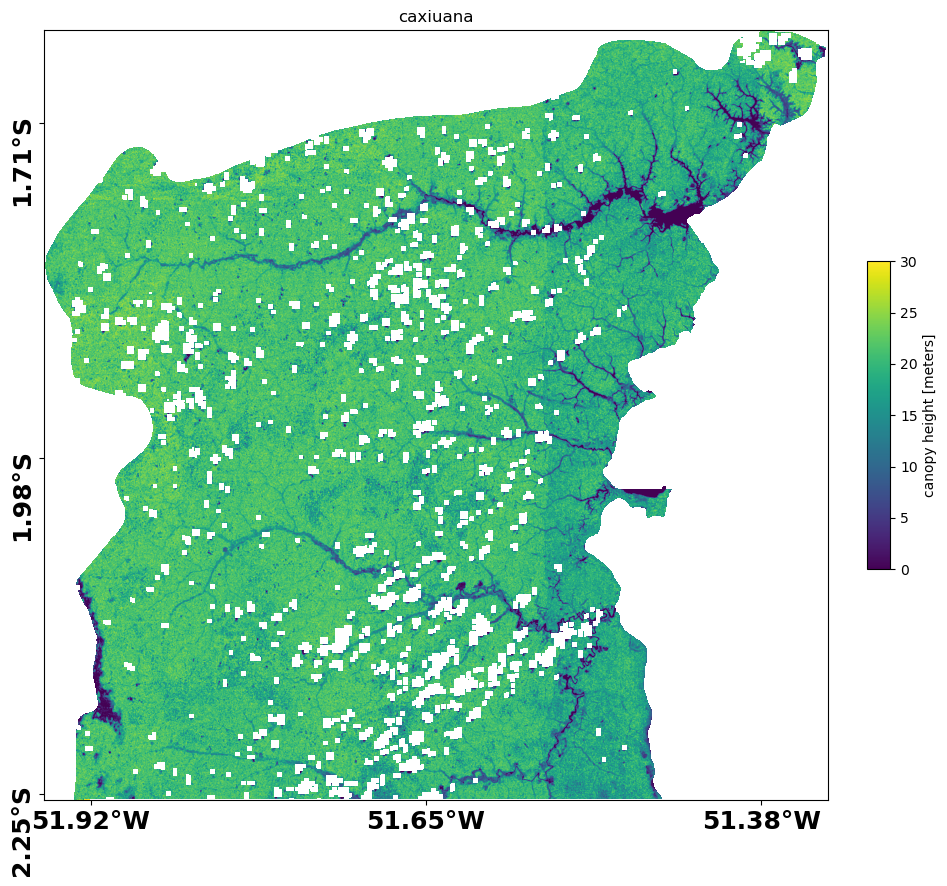

In [21]:
title='caxiuana'
fig, ax = plt.subplots(1, 1, figsize=[14, 10])
bbox=box(*bounds)
extent = (bbox.bounds[0], bbox.bounds[2], bbox.bounds[1], bbox.bounds[3])
colors=ax.imshow(chm, vmax=np.nanpercentile(chm,99.5), extent=extent)
tt = ax.get_xticks()[1:-1]
ax.set_xticks(tt[::3])
tt = ax.get_yticks()[1:-1]
ax.set_yticks(tt[::3])
mercator_to_latlon_ax(ax, dec=2)
cax = plt.gca().inset_axes([1.05, 0.3, 0.03, 0.4])
plt.colorbar(colors, cax=cax, label='canopy height [meters]')
ax.set_title(title)
plt.savefig(f'/Users/jetolan/Desktop/ICMBIO/figs/{title}.png', dpi=300)

# plot observation dates

In [22]:
all_polys=[]
for ff in metas:
    gdf=gp.read_file(ff)
    all_polys.append(gp.overlay(gdf, target))
meta_gdf=pd.concat(all_polys)

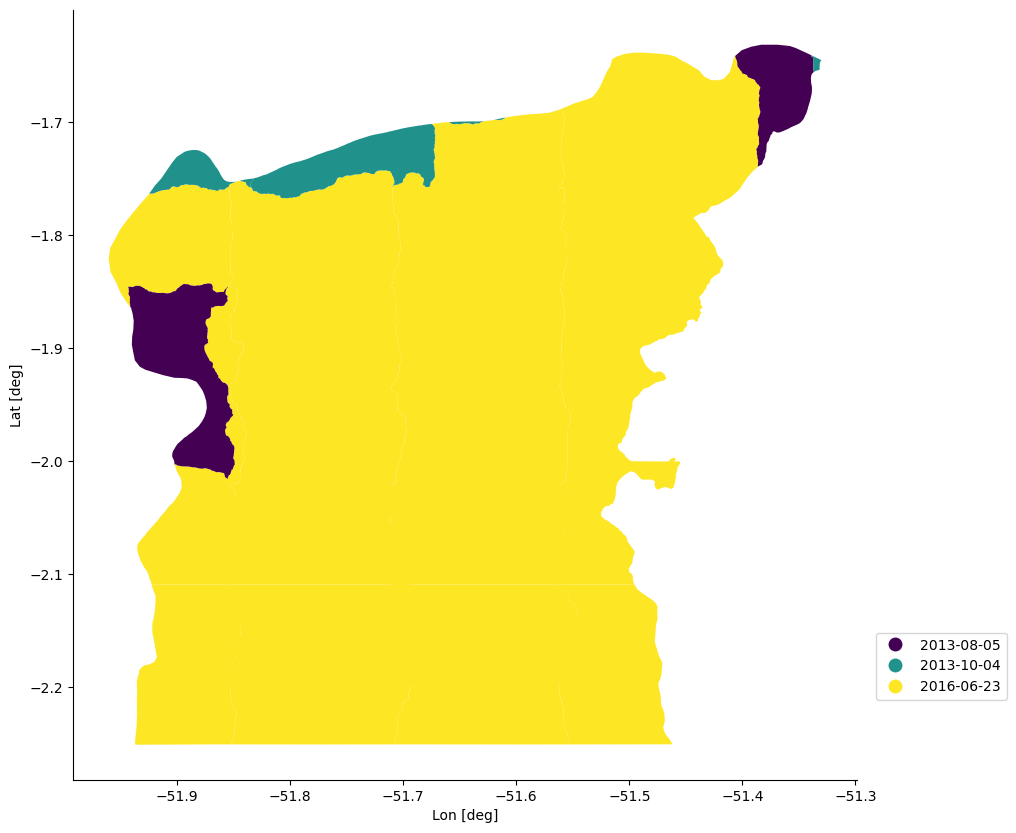

In [171]:
fig, ax = plt.subplots(1, 1, figsize=[14, 10])
meta_gdf.plot(ax=ax, column="acq_date", cmap='viridis', legend=True)
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')
ax.spines[['right', 'top']].set_visible(False)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 0., 0.2, 0.2))
plt.savefig(f'/Users/jetolan/Desktop/ICMBIO/figs/{title}_obsdate.png', dpi=300)

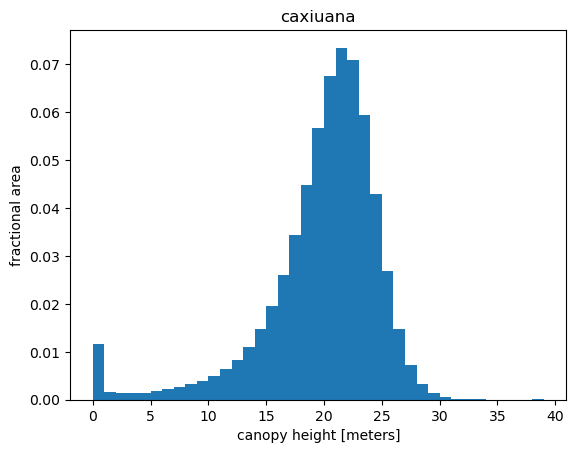

In [29]:
#histogram of canopy height across entire conservation area
chm_flat=chm.flatten()
bins=np.arange(0,40)
plt.hist(chm_flat, bins=bins, weights=np.ones(len(chm_flat)) / len(chm_flat))
plt.xlabel('canopy height [meters]')
plt.ylabel('fractional area')
plt.title(title)
plt.savefig(f'/Users/jetolan/Desktop/ICMBIO/figs/{title}_hist.png', dpi=300)